In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv('pr13_stocks (1).csv', index_col=0)
# df = df.sample(frac=0.05, random_state=42)  
# df = df[df['Ticker']=='CL']

(100000, 12)
Date             object
Dividends       float64
Stock Splits    float64
Brand_Name       object
Ticker           object
Industry_Tag     object
Country          object
Volume          float64
Open            float64
High            float64
Low             float64
Close           float64
dtype: object
                        Date  Dividends  Stock Splits  \
0  2021-01-25 00:00:00-05:00        0.0           0.0   
1  2019-09-12 00:00:00-04:00        0.0           0.0   
2  2015-12-29 00:00:00-05:00        0.0           0.0   
3  2014-06-13 00:00:00-04:00        0.0           0.0   
4  2017-10-06 00:00:00-04:00        0.0           0.0   

                Brand_Name Ticker    Industry_Tag      Country      Volume  \
0                    crocs   CROX        footwear          usa   1102500.0   
1                   target    TGT          retail          usa   3185700.0   
2                 unilever     UL  consumer goods  netherlands   1278700.0   
3                      amd    

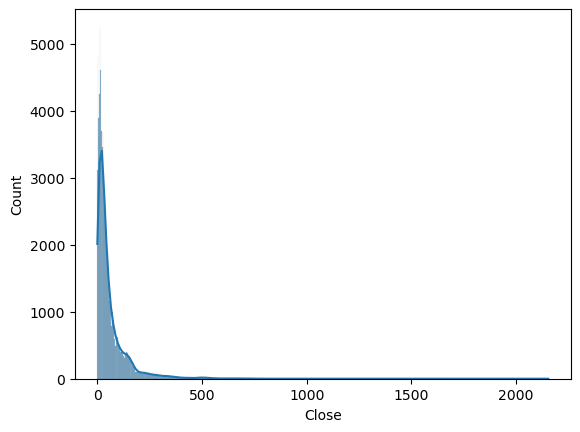

Number of duplicates: 0
Number of Missing Values: 4261
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          99984 non-null  object 
 1   Dividends     99941 non-null  float64
 2   Stock Splits  99542 non-null  float64
 3   Brand_Name    99775 non-null  object 
 4   Ticker        99825 non-null  object 
 5   Industry_Tag  99966 non-null  object 
 6   Country       99900 non-null  object 
 7   Volume        99148 non-null  float64
 8   Open          99197 non-null  float64
 9   High          99336 non-null  float64
 10  Low           99319 non-null  float64
 11  Close         99806 non-null  float64
dtypes: float64(7), object(5)
memory usage: 9.9+ MB


,Dividends,Stock Splits,Volume,Open,High,Low,Close
count,99941.000000,99542.000000,9.914800e+04,99197.000000,99336.000000,99319.000000,99806.000000
mean,0.003058,0.000536,2.347898e+07,65.486750,66.153202,64.724860,65.467484
std,0.044493,0.050264,8.820551e+07,118.103474,119.203651,116.686773,117.964329
min,0.000000,0.000000,0.000000e+00,0.199012,0.199922,0.196739,0.199164
25%,0.000000,0.000000,1.354575e+06,15.060389,15.268422,14.853267,15.043717
50%,0.000000,0.000000,4.621250e+06,32.457324,32.835369,32.076428,32.505058
75%,0.000000,0.000000,1.228455e+07,72.571576,73.143646,71.884888,72.491188
max,2.012000,10.000000,2.768427e+09,2152.699951,2173.629883,2119.989990,2153.199951


In [6]:
#General Information about the Dataset
print(df.shape) 
print(df.dtypes) 
print(df.head())
sns.histplot(data=df, x='Close', bins='auto', kde=True)
plt.show()
print('Number of duplicates:', np.sum(df.duplicated()))
print('Number of Missing Values:', df.isnull().sum().sum())
#General Descriptives about the Dataset
df.info()
df.describe()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
#drop the 16 rows without any date data
df = df.dropna(subset=['Date'])
#drop the row without both Brand_name and Ticker as we cannot say which company this entry refers to
df = df[~(df['Brand_Name'].isna() & df['Ticker'].isna())].copy()

df['Brand_Name'] = df['Brand_Name'].str.lower()
df['Ticker'] = df['Ticker'].str.upper()

brand_to_ticker = df.dropna(subset=['Brand_Name', 'Ticker'])\
                        .drop_duplicates(subset=['Brand_Name'])\
                        .set_index('Brand_Name')['Ticker'].to_dict()

ticker_to_brand = df.dropna(subset=['Brand_Name', 'Ticker'])\
                        .drop_duplicates(subset=['Ticker'])\
                        .set_index('Ticker')['Brand_Name'].to_dict()

    # Fill missing Ticker using Brand_Name
df.loc[df['Ticker'].isna() & df['Brand_Name'].notna(), 'Ticker'] = (
        df.loc[df['Ticker'].isna() & df['Brand_Name'].notna(), 'Brand_Name']
        .map(brand_to_ticker)
    )

    # Fill missing Brand_Name using Ticker
df.loc[df['Brand_Name'].isna() & df['Ticker'].notna(), 'Brand_Name'] = (
    df.loc[df['Brand_Name'].isna() & df['Ticker'].notna(), 'Ticker']
    .map(ticker_to_brand))



#As dividend payments and stock splits are sparse, event-based features, missing values here are likely because 
#no such event has occured. Therefore, missing values are filled with 0. Also, the occurence of missing values 
#is relatively low here(59 and 458, respectively) compared to the overall dataset size(~100,000)
df['Dividends'] = df['Dividends'].fillna(0.0)
df['Stock Splits'] = df['Stock Splits'].fillna(0.0)




#Imputing industry tag values with the most frequent value for each brand

df['Industry_Tag'] = df['Industry_Tag'].str.strip().str.lower()
industry_map = (
        df.dropna(subset=['Industry_Tag'])
          .groupby('Brand_Name')['Industry_Tag']
          .agg(lambda x: x.mode()[0]) 
          .to_dict()
    )

df['Industry_Tag'] = df.apply(
        lambda row: industry_map[row['Brand_Name']]
        if pd.isna(row['Industry_Tag']) or row['Industry_Tag'] != industry_map.get(row['Brand_Name'])
        else row['Industry_Tag'],
        axis=1
    )

#same for country

df['Country'] = df['Country'].str.strip()

country_map = (
        df.dropna(subset=['Country'])
          .groupby('Brand_Name')['Country']
          .agg(lambda x: x.mode()[0]) 
          .to_dict()
    )

df['Country'] = df.apply(
        lambda row: country_map[row['Brand_Name']]
        if pd.isna(row['Country']) or row['Country'] != country_map.get(row['Brand_Name'])
        else row['Country'],
        axis=1
    )

#drop Open High Low since they give information at the same day as they are not independent of the Close price --> our target
# drop Brand Name as it contains the same info as Ticker
df = df.drop(columns=['Open', 'High', 'Low','Brand_Name'])
#drop all nans in target and the corresponding rows -->hard to predict without target
print(df.shape,'shape before Close dropped')
df = df.dropna(subset=['Close'])
print(df.shape,'shape before vol dropped')
#drop all nans in volumne and the corresponding rows
df = df.dropna(subset=['Volume'])
print(df.shape,'shape after vol dropped')


#we decided not to exclude outliers, however they are defined, since we expect the models to learn from these 'special' circumstances.


(99789, 8) shape before vol dropped
(98937, 8) shape after vol dropped


In [ ]:
duplicated = df[df.duplicated(subset=['Ticker', 'Date'], keep=False)]
duplicated
#drop all duplicates if the ticker and Date are the same
df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='first')

In [ ]:
#check
print(df.isna().sum())
df

Date            0
Dividends       0
Stock Splits    0
Ticker          0
Industry_Tag    0
Country         0
Volume          0
Close           0
dtype: int64


In [ ]:
#include new time features, since we expected to find some pattern of the time, e.g. an increase over the years (that we see), or an increase on certain days of the week or the year (cannot observe that).
df['Date'] = pd.to_datetime(df['Date']) 

# Time-based features
df['Year'] = df['Date'].dt.year.astype('int32')
df['Month'] = df['Date'].dt.month.astype('int32')
df['Day'] = df['Date'].dt.dayofyear.astype('int32')
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('int32')  # 0 = Monday, 6 = Sunday

# Running day number to determine the date on, rather than a datetime type
df['Day_Number'] = (df['Date'] - df['Date'].min()).dt.days
df = df.sort_values(by='Date').reset_index(drop=True)

In [ ]:
#we wanted to add the past close prices, volumnes and the time distance to the current date in days to the df
def add_lags(df, lags):
    for lag in lags:
        df[f'Close_Lag_{lag}' ] = df.groupby('Ticker' )['Close'].shift(lag)
        df[f'Volume_Lag_{lag}' ] = df.groupby('Ticker')['Volume'].shift(lag)
        df[f'Days_Since_Lag_{lag}' ] = df.groupby('Ticker')['Date'].diff(lag).dt.days
    return df


In [ ]:
#we wanted to implement a time weighted mean and std to the df. because our initial function took over 30min we improved speed with numba
from numba import njit

#calculate the weighted mean and std using numba (dramatic time reduction)
@njit
def weighted_mean_std_numba(close_lags, days_diff):

    if np.sum(days_diff) == 0:
        return np.nan, np.nan

    weight = 1.0/days_diff
    weight_sum = np.sum(weight)


    if weight_sum == 0.0 or np.any(np.isnan(weight)) or np.any(np.isinf(weight)):
        return np.nan, np.nan



    weighted_mean = np.sum(weight* close_lags) /weight_sum
    weighted_var = np.sum(weight*(close_lags- weighted_mean)**2) /weight_sum
    weighted_std = np.sqrt(weighted_var)

    return weighted_mean, weighted_std

def add_weighted_mean_std_numba(df, lookback_periods):
    df = df.sort_values(['Ticker', 'Date']).copy()

    for lookback in lookback_periods:
        weighted_means = np.full(len(df),np.nan)
        weighted_stds = np.full(len(df), np.nan)

        idx = df.index.to_numpy()
        closes = df['Close'].to_numpy()
        dates = pd.to_datetime(df['Date']).values.astype('datetime64[D]')
        tickers = df['Ticker'].to_numpy()

        unique_tickers = np.unique(tickers)

        for ticker in unique_tickers:

            ticker_mask = tickers == ticker
            ticker_indices = np.where(ticker_mask)[0]

            for i in range(lookback, len(ticker_indices)):

                idx_range = ticker_indices[i - lookback:i]
                current_idx = ticker_indices[i]


                close_lags = closes[idx_range]

                date_lags = dates[idx_range]
                current_date = dates[current_idx]
                days_diff = (current_date - date_lags).astype(np.int64)



                if np.any(days_diff == 0) or np.any(np.isnan(close_lags)):
                    continue 

                mean_val, std_val = weighted_mean_std_numba(close_lags , days_diff)
                weighted_means[current_idx] =mean_val
                weighted_stds[current_idx] = std_val

        df[f'Weighted_Mean_{lookback}']= weighted_means
        df[f'Weighted_Std_{lookback}']= weighted_stds

    return df


In [ ]:
#we also wanted to see how simply shifting the lookback period would influence the feature, without taking the timing differnce into account.
def add_simple_mean_std(df, lookback_periods):
    df = df.sort_values(['Ticker', 'Date']).copy()

    for lookback in lookback_periods:

        means =[]
        stds =[]
        for ticker, group in df.groupby('Ticker'):

            group = group.sort_values('Date')
            closes = group['Close_Lag_1'].reset_index(drop=True)
            mean_vals = closes.rolling(window=lookback,min_periods=lookback).mean()
            std_vals = closes.rolling(window=lookback, min_periods=lookback).std()

            means.append(pd.Series(mean_vals.values, index=group.index))
            stds.append(pd.Series(std_vals.values, index=group.index))


        df[f'Simple_Mean_{lookback}'] =pd.concat(means)
        df[f'Simple_Std_{lookback}'] =pd.concat(stds)

    return df

In [ ]:
#we added the return of the previous day
def add_returns(df):
    df['return_since_last_entry'] = df['Close_Lag_1']/df['Close_Lag_2'] -1

    return df

In [ ]:
#we added the Close price difference of the previous day
def add_diff(df):
    df['diff_since_last_entry'] = df['Close_Lag_1']-df['Close_Lag_2']

    return df

In [ ]:
#since so many rows for dividends and stock splits are zero we wanted to add a signal for it to the df
def add_cat_signals(df, cols):
    for col in cols:
        new_col = f"{col}_signal"
        df[new_col] = (df[col] != 0).astype('int32')
    return df

In [ ]:
df = add_lags(df, [1,2,3,4,5,10,20,30,40,50,60,70,80,90,100])

In [ ]:
df = add_weighted_mean_std_numba(df,[2,3,4,5,10,20,30,40,50,60,70,80,90,100])


In [ ]:
df = add_simple_mean_std(df,[2,3,4,5,10,20,30,40,50,60,70,80,90,100])


In [ ]:
df = add_returns(df)


In [ ]:
df = add_diff(df)


In [ ]:
df = add_cat_signals(df, ['Dividends','Stock Splits'])

In [ ]:
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(df.columns)
df.isna().sum()

Index(['Date', 'Dividends', 'Stock Splits', 'Ticker', 'Industry_Tag',
       'Country', 'Volume', 'Close', 'Year', 'Month',
       ...
       'Simple_Mean_80', 'Simple_Std_80', 'Simple_Mean_90', 'Simple_Std_90',
       'Simple_Mean_100', 'Simple_Std_100', 'return_since_last_entry',
       'diff_since_last_entry', 'Dividends_signal', 'Stock Splits_signal'],
      dtype='object', length=118)


Date                          0
Dividends                     0
Stock Splits                  0
Ticker                        0
Industry_Tag                  0
Country                       0
Volume                        0
Close                         0
Year                          0
Month                         0
Day                           0
DayOfWeek                     0
Day_Number                    0
Close_Lag_1                  61
Volume_Lag_1                 61
Days_Since_Lag_1             61
Close_Lag_2                 122
Volume_Lag_2                122
Days_Since_Lag_2            122
Close_Lag_3                 183
Volume_Lag_3                183
Days_Since_Lag_3            183
Close_Lag_4                 244
Volume_Lag_4                244
Days_Since_Lag_4            244
Close_Lag_5                 305
Volume_Lag_5                305
Days_Since_Lag_5            305
Close_Lag_10                610
Volume_Lag_10               610
Days_Since_Lag_10           610
Close_La

In [ ]:
#since date is in the datetime type and the information of time is preserved in the Day_number column we can delete it
df = df.drop('Date', axis=1)
#we need to delete Volumne since it contains information to some extend about the same day. therefore we cannot use it. remeber we still have a lagged volumne in the df
df = df.drop('Volume', axis=1)
# print(df['Stock Splits_signal'].sum())

In [ ]:
# df.to_csv('pr13_all_cols.csv', index=False)

In [ ]:
# num_ticks = 5


# plt.figure(figsize=(8, 6))
# sns.stripplot(data=df, x="Close", y="Year", hue="Ticker", legend=False)

# xmin, xmax = plt.xlim()
# tick_positions = np.linspace(xmin, xmax, num_ticks)
# tick_labels = [f"{pos:.2f}" for pos in tick_positions]

# plt.title('Close vs Year')
# plt.xticks(tick_positions, tick_labels)
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.stripplot(data=df, x="Close", y="Month", hue="Ticker", legend=False)
# plt.title('Close vs Month')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.stripplot(data=df, x="Close", y="Day", hue="Ticker", legend=False)
# plt.title('Close vs Day')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.stripplot(data=df, x="Close", y="DayOfWeek", hue="Ticker", legend=False)
# plt.title('Close vs DayOfWeek')
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.stripplot(x='Country', y='Close', data=df, jitter=True, palette='deep')
# plt.title('Country vs Close - Stripplot')
# plt.xticks(rotation=45)
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.stripplot(x='Industry_Tag', y='Close', data=df, jitter=True, palette='muted')
# plt.title('Industry vs Close - Stripplot')
# plt.xticks(rotation=45)
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.stripplot(x='Ticker', y='Close', data=df, jitter=True, palette='bright')
# plt.title('Ticker vs Close - Stripplot')
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
# # 'pairplot of close, div, stock split, theri signal'
# sns.pairplot(df[['Close', 'Dividends', 'Stock Splits', 'Dividends_signal', 'Stock Splits_signal']], diag_kind="kde", corner=True)
# plt.show()


In [ ]:
# print(max(df['Close']),min(df['Close']))

In [ ]:
# def corr_per_ticker(df,n_features = 10):
#         list = []
#         for ticker, group in df.groupby('Ticker'):
#                 corr_matrix = df[ticker].corr()
#                 target_corr = corr_matrix['Close'].drop('Close').sort_values(ascending=False)
#                 print(f"\n Top {n_features} for {ticker} features by Pearson correlation with Close:\n")
#                 print(target_corr)
#                 list += (ticker,)

n=30
def analyze_correlation(df, n_features=n):
    # Keep numeric columns + Ticker separately
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Close' not in numeric_cols:
        raise ValueError("'Close' must be in your DataFrame and numeric.")

    if 'Ticker' not in df.columns:
        raise ValueError("'Ticker' must be in your DataFrame.")

    results = []

    # Step 1: Calculate correlations
    for ticker, group in df.groupby('Ticker'):
        if len(group) < 2:
            continue  # skip tickers with not enough data

        group_numeric = group[numeric_cols]  # <-- only numeric columns here!

        corr_matrix = group_numeric.corr()
        target_corr = corr_matrix['Close'].drop('Close').sort_values(ascending=False)

        top_features = target_corr.head(n_features)

        for rank, (feature_name, correlation) in enumerate(top_features.items(), start=1):
            results.append({
                'Ticker': ticker,
                'Feature': feature_name,
                'Correlation': correlation,
                'Rank': rank
            })

    # Step 2: Create a nice DataFrame from results
    results_df = pd.DataFrame(results)

    return results_df


results_df = analyze_correlation(df) 


In [ ]:
# unique_features, counts = np.unique(results_df['Feature'], return_counts=True)

# Combine the unique features and their counts into a DataFrame
feature_distribution = pd.DataFrame({'Feature': unique_features, 'Count': counts})

threshold = n/2  # Change this to whatever threshold you want

# Filter features that meet the threshold condition
filtered_distribution = feature_distribution[feature_distribution['Count'] > threshold]

# Plot the distribution using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_distribution['Feature'], filtered_distribution['Count'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Feature Distribution (Filtered by Count Threshold)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def analyze_mutual_info(df, n_features=n):
    # Keep numeric columns + Ticker separately
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Close' not in numeric_cols:
        raise ValueError("'Close' must be in your DataFrame and numeric.")

    if 'Ticker' not in df.columns:
        raise ValueError("'Ticker' must be in your DataFrame.")

    results = []

    # Step 1: Calculate mutual information
    for ticker, group in df.groupby('Ticker'):
        if len(group) < 2:
            continue  # skip tickers with not enough data

        # Drop rows with NaN values in any numeric columns
        group = group.dropna(subset=numeric_cols)

        if len(group) < 2:  # Check again after dropping NaNs
            continue

        group_numeric = group[numeric_cols]  # <-- only numeric columns here!
        
        # Drop 'Close' and other non-predictive columns
        X = group_numeric.drop('Close', axis=1)
        y = group_numeric['Close']

        # Calculate mutual information between 'Close' and other features
        mutual_info = mutual_info_regression(X, y)

        # Create a pandas Series to associate mutual information with feature names
        mutual_info_series = pd.Series(mutual_info, index=X.columns)

        # Sort by mutual information (descending) and pick the top n_features
        top_features = mutual_info_series.sort_values(ascending=False).head(n_features)

        for rank, (feature_name, mi_value) in enumerate(top_features.items(), start=1):
            results.append({
                'Ticker': ticker,
                'Feature': feature_name,
                'Mutual Information': mi_value,
                'Rank': rank
            })

    # Step 2: Create a nice DataFrame from results
    results_df = pd.DataFrame(results)

    return results_df


In [ ]:
mi_results_df = analyze_mutual_info(df)


In [ ]:
unique_features, counts = np.unique(mi_results_df['Feature'], return_counts=True)

# Combine the unique features and their counts into a DataFrame
feature_distribution = pd.DataFrame({'Feature': unique_features, 'Count': counts})

threshold = n/2  # Change this to whatever threshold you want

# Filter features that meet the threshold condition
filtered_distribution = feature_distribution[feature_distribution['Count'] > threshold]

# Plot the distribution using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_distribution['Feature'], filtered_distribution['Count'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Feature Distribution (Filtered by Count Threshold)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# import pandas as pd
# import plotly.express as px

# def plot_interactive_pairplot_whole_df(df):
#     # Create the pairplot using Plotly Express for the entire DataFrame
#     fig = px.scatter_matrix(
#         df,
#         dimensions=df.select_dtypes(include='number').columns,  # Automatically selects numeric columns
#         color='Ticker',  # Color points by ticker (for better distinction between tickers)
#         title="Interactive Pairplot for All Tickers",
#         labels={col: col for col in df.select_dtypes(include='number').columns},  # Label the columns nicely
#     )
    
#     # Show the plot
#     fig.show()

# # Example usage:
# # Assuming 'df' is your DataFrame with columns like 'Ticker', 'Open', 'Close', 'High', 'Low', etc.
# # df = pd.read_csv('your_data.csv')  # Load your data
# plot_interactive_pairplot_whole_df(df)


In [ ]:
# from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def pre_training_analysis_v2(df, target='Close', top_n=6, drop_low_variance=True, variance_threshold=0.01, save_plots=False):
#     """
#     Extended EDA for regression:
#     - Drops low-variance features
#     - Correlation + Mutual Info
#     - Histograms, KDEs
#     - Pairplots
#     - Scatterplots
#     - VIF check for multicollinearity
    
#     Parameters:
#     - df (pd.DataFrame): Data
#     - target (str): Target column
#     - top_n (int): Number of top features to show
#     - drop_low_variance (bool): Drop near-constant columns
#     - variance_threshold (float): Threshold for variance filter
#     - save_plots (bool): Optionally save key plots
#     """

#     # 0. Numerical subset
#     numeric_df = df.select_dtypes(include=['float64', 'int32', 'int64']).copy()

#     # 1. Handle NaNs
#     numeric_df = numeric_df.dropna()
#     print(f"✅ Dropped rows with NaNs. Data shape: {numeric_df.shape}")

#     # 2. Drop low-variance
#     if drop_low_variance:
#         features = numeric_df.drop(columns=[target], errors='ignore')
#         selector = VarianceThreshold(threshold=variance_threshold)
#         selector.fit(features)
#         retained_columns = features.columns[selector.get_support()]
#         dropped_columns = features.columns[~selector.get_support()]
        
#         print(f"\n⚠️ Dropping {len(dropped_columns)} low-variance features:\n{dropped_columns.tolist()}\n")
#         numeric_df = numeric_df[retained_columns.tolist() + [target]]

#         # Variance Barplot
#         plt.figure(figsize=(10, 4))
#         sns.barplot(x=retained_columns, y=selector.variances_[selector.get_support()])
#         plt.xticks(rotation=90)
#         plt.title("Retained Feature Variances")
#         if save_plots:
#             plt.savefig("retained_variances.png", dpi=300, bbox_inches="tight")
#         plt.show()

#     # 3. Correlation
#     corr_matrix = numeric_df.corr()
#     target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)
    
#     print(f"\n📈 Top {top_n} features by Pearson correlation with '{target}':\n")
#     print(target_corr)

#     # 4. Mutual Information
#     # X = numeric_df.drop(columns=[target])
#     # y = numeric_df[target]
#     # mi_scores = mutual_info_regression(X, y, random_state=42)
#     # mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

#     # print(f"\n🧠 Top {top_n} features by Mutual Information with '{target}':\n")
#     # print(mi_series.head(top_n))

#     # # 5. VIF (Variance Inflation Factor) for multicollinearity
#     # vif_data = pd.DataFrame()
#     # vif_data['Feature'] = X.columns
#     # vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     # vif_data = vif_data.sort_values(by='VIF', ascending=False)
    
#     # print(f"\n🧠 Top {top_n} features by VIF (higher = more multicollinearity):\n")
#     # print(vif_data.head(top_n))

#     # --- PLOTS ---
#     # 6. Correlation heatmap
#     plt.figure(figsize=(10, 10))
#     sns.heatmap(corr_matrix[[target]].sort_values(by=target, ascending=False), annot=True, cmap='coolwarm', linewidths=0.5)
#     plt.title(f"Correlation with '{target}'", fontsize=14)
#     if save_plots:
#         plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")
#     plt.show()

#     # 7. KDE + Histograms of top mutual info features
#     top_features = target_corr.head(top_n).index.tolist()
#     for feature in top_features:
#         fig, ax = plt.subplots(1, 2, figsize=(12, 4))
#         sns.histplot(numeric_df[feature], kde=False, ax=ax[0], color='skyblue')
#         ax[0].set_title(f"Histogram of {feature}")
#         sns.kdeplot(numeric_df[feature], ax=ax[1], fill=True, color='orange')
#         ax[1].set_title(f"KDE of {feature}")
#         ax.set()
#         if save_plots:
#             fig.savefig(f"hist_kde_{feature}.png", dpi=300, bbox_inches="tight")
#         plt.show()

#     # 8. Scatterplots against target
#     for feature in top_features:
#         plt.figure(figsize=(8, 4))
#         sns.scatterplot(x=numeric_df[feature], y=numeric_df[target], alpha=0.5)
#         plt.title(f"Scatterplot: {feature} vs {target}")
#         if save_plots:
#             plt.savefig(f"scatter_{feature}_vs_{target}.png", dpi=300, bbox_inches="tight")
#         plt.show()

#     # 9. Pairplot of top 5 MI features + target
#     pairplot_features = top_features[:min(5, len(top_features))] + [target]
#     sns.pairplot(numeric_df[pairplot_features], diag_kind="kde", corner=True)
#     plt.suptitle(f"Pairplot of Top {top_n} MI Features + '{target}'", y=1.02)
#     if save_plots:
#         plt.savefig("pairplot_top_features.png", dpi=300, bbox_inches="tight")
#     plt.show()

#     print("\n🎯 Analysis complete!")

    



In [ ]:
# pre_training_analysis_v2(df, top_n=10, drop_low_variance=True)

NameError: name 'pre_training_analysis_v2' is not defined